## A feed-forward Neural Network for MNIST digit classification with 2 hidden layers

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

%matplotlib inline
# get_ipython().magic('matplotlib auto')
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
from datetime import timedelta
import math
import timeit
import os

In [2]:
# Import mnist data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
# print the no of examples from training, test and validation sets
print(mnist.train.num_examples, mnist.test.num_examples, mnist.validation.num_examples)

55000 10000 5000


In [4]:
# Print the shape of image examples from the training, validation, and test sets
print(mnist.train.images.shape[1], mnist.train.labels.shape[1])
print(mnist.validation.images.shape[1], mnist.validation.labels.shape[1])
print(mnist.test.images.shape[1], mnist.test.labels.shape[1])

784 10
784 10
784 10


In [5]:
# One-Hot encoded labels for the first 9 images in the test set
print(mnist.test.labels[0:9, :])

# classes (output features) are needed as single numbers for comparisions and performance measures
# convert the one-hot encoded vectors to a single number by taking the index of the highest element

mnist.test.cls = np.argmax(mnist.test.labels, axis=1)
print(mnist.test.cls[0:9])

mnist.validation.cls = np.argmax(mnist.validation.labels, axis=1)
print(mnist.validation.cls[0:9])

[[ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]]
[7 2 1 0 4 1 4 9 5]
[5 0 4 1 9 2 1 3 1]


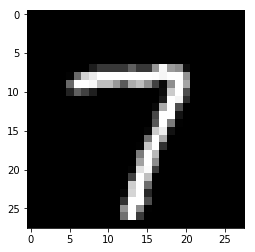

In [6]:
# Visualize any one of the images by reshaping it to a 28x28 image
plt.imshow(np.reshape(mnist.train.images[100, :], (28, 28)), cmap='gray')
plt.show()

In [7]:
# Data Dimensions
img_size = 28

# store the images as one-dimensional arrays
img_size_flat = img_size * img_size

# No of channels
n_channels = 1

# tuple with height and width of images to reshape arrays
img_shape = (img_size, img_size)
print("Shape of the image:", img_shape)

Shape of the image: (28, 28)


In [8]:
# FFN network parameters
# No of input features
n_input = img_size_flat

# No of output features
n_output = 10

# No of units in each hidden layer
n_hidden1 = 1024
n_hidden2 = 1024

In [9]:
# Training Parameters
learning_rate = 0.01
batch_size = 32

In [10]:
# Initialize placeholder for input
x = tf.placeholder(tf.float32, [None, n_input])

# Initialize placeholder for output
y_true = tf.placeholder(tf.float32, [None, n_output])

# Initialize placeholder for true class of each image in x
y_true_cls = tf.argmax(y_true, dimension=1)

In [11]:
# Initialize placeholder for weights
# Define a weight initialization function
def init_weights(shape):
    # weights = tf.Variable(tf.random_normal(shape, stddev=1.0))
    W_bound = np.sqrt(1. / (n_input + n_output))
    weights = tf.Variable(tf.random_uniform(maxval=-W_bound, minval=W_bound, shape=shape))
    return weights

In [12]:
# Initialize placholder for biases
# Define a bias initialization function
def init_biases(shape):
#     biases = tf.Variable(tf.random_normal(shape))
    biases = tf.Variable(tf.zeros(shape))
    return biases

# Forward Propagation

## Hidden Layer 1

In [13]:
# Initialize placeholders for Hidden Layer 1
W_1 = init_weights(shape=[n_input, n_hidden1])
b_1 = init_biases(shape=[n_hidden1])
    
# Compute the output for the hidden layer 1 using the ReLU activation function
hidden1 = tf.nn.relu(tf.matmul(x, W_1) + b_1)
print(hidden1.shape)

(?, 1024)


## Hidden Layer 2

In [14]:
# Initialize placeholders for Hidden Layer 2
W_2 = init_weights(shape=[n_hidden1, n_hidden2])
b_2 = init_biases(shape=[n_hidden2])

# Compute the output for the hidden layer 1 using the ReLU activation function
hidden2 = tf.nn.relu(tf.matmul(hidden1, W_2) + b_2)
print(hidden2.shape)

(?, 1024)


## Final Layer

In [15]:
# Initialize placeholders for the output/final layer

W_3 = init_weights(shape=[n_hidden2, n_output])
b_3 = init_biases(shape=[n_output])
    
# Compute the output for the final layer (no need to use to activation function here)
logits = tf.matmul(hidden2, W_3) + b_3
print(logits.shape)

(?, 10)


In [16]:
# Normalize the output values of the logits between 0 and 1 so that each row of the logits matrix sums to 1
y_pred = tf.nn.softmax(logits=logits)

# Calculate the predicted class from y_pred by taking the index of the largest element in each row.
y_pred_cls = tf.argmax(y_pred, dimension=1)

## Loss, Optimization, and Accuracy - Automatic Differentiation

In [17]:
# Compute the loss using softmax_cross_entropy with logits activation function
# Find the average of the loss to guide the model's variables towards optimization
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_true, logits=logits))

In [18]:
# Initialize the optimization alogrithm
optimizer = tf.train.AdamOptimizer(learning_rate)

# Track each global step towards optimization
global_step = tf.Variable(0, name='global_step', trainable=False)

# Reduce the loss using GradientDescent Optimization
# and increment the global step counter as a single training step
optimizer = optimizer.minimize(loss, global_step=global_step)

In [19]:
# Compute the accuracy of the model

# Compare the true labels of the images to the predicted labels from the output
correct_prediction = tf.equal(y_pred_cls, y_true_cls)

# calculate the classification accuracy by type-casting the vector of booleans to floats (False=0, True=1), and
# then find the average
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

## Divide the Training, Validation, and Test Sets into Minibatches

In [20]:
n_train_batches = mnist.train.num_examples // batch_size
n_valid_batches = mnist.validation.num_examples // batch_size
n_test_batches = mnist.test.num_examples // batch_size

print("# of Training batches", n_train_batches)
print("# of Validation batches", n_valid_batches)
print("# of Test batches", n_test_batches)

# of Training batches 1718
# of Validation batches 156
# of Test batches 312


## Initialize the TensorFlow Session

In [21]:
# Intialize all variables and Create TensorFlow session
init = tf.global_variables_initializer()
sess = tf.Session()

## Save the model

In [22]:
# Create a saver object to save all the variables of the neural network for storing and retrieving it later.

saver = tf.train.Saver()

# create a directory for saving the checkpoints that get written at regular intervals during optimization
save_dir = "checkpoints_mnist_ffn_2h_relu/"
# create the directory if it doesn't exist
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    
# path for the checkpoint file
save_path = os.path.join(save_dir, "mnist_ffn512.ckpt")
if os.path.exists(save_path):
    print("Checkpoint created.")
else:
    print("No checkpoint exists as of now!!!!")

No checkpoint exists as of now!!!!


## Restore or Initialize Variables for TensorFlow Graph

In [23]:
# restore the latest checkpoint if available from the checkpoint directory
try:
    print("Trying to restore the latest checkpoint....")
    
    # search for the latest checkpoint
    last_ckpt_path = tf.train.latest_checkpoint(checkpoint_dir=save_dir)
    
    # load the data from the checkpoint file
    saver.restore(sess, save_path=last_ckpt_path)
    
    print("Checkpoint restored from: ", last_ckpt_path)
except:
    print("Failed to restore checkpoint. Initializing variables instead...")
    sess.run(init)

Trying to restore the latest checkpoint....
Failed to restore checkpoint. Initializing variables instead...


## Helper Function to Perform Training

In [24]:
def optimize(n_epochs):
    
    finished = False
    curr_epoch = 0
    
    # start the timer
    start_time = timeit.default_timer()
    
    while (curr_epoch < n_epochs) and (not finished):
        
        # increment the no of iterations by 1
        curr_epoch += 1
        
        # get a batch of training examples
        # x_batch for images and y_batch for labels of these images
        x_batch, y_true_batch = mnist.train.next_batch(batch_size)
        
        # create a dictionary of above training batches that needs to be fed to the placeholder variables
        # y_true_cls is not set as it is not used during training
        feed_dict_train = {x: x_batch, y_true: y_true_batch}
        
        for minibatch_i in range(n_train_batches):
            
            # iteration number
            iter = (curr_epoch - 1) * n_train_batches + minibatch_i
            
            if ((iter + 1) % n_train_batches == 0):
        
                # run the optimizer using the batch of training data
                # retrieve the global step counter
                global_step_, optimizer_, cost_ = sess.run([global_step, optimizer, loss], 
                                                           feed_dict=feed_dict_train)
            
                # calculate the accuracy of the training set.
                train_accuracy = sess.run(accuracy, feed_dict=feed_dict_train)

                # calculate the accuracy of the validation set.
                valid_accuracy, _ = validation_accuracy()
                
                epoch_msg = ("Epoch %i, Minibatch %i/%i ") % (curr_epoch, minibatch_i+1, n_train_batches)
                print(epoch_msg)

                # print the accuracy message
                output = "Training Accuracy: {0:>6.1%}, Validation Accuracy: {1:>6.1%}"
                print(output.format(train_accuracy, valid_accuracy))
            
#                 print("Training Cost: ", cost_)
                
                
                # save all variables to a checkpoint and append the total_interations counter to the filename
                saver.save(sess, save_path=save_path, global_step=global_step_)
                print("Checkpoint Saved...")
                
                print("=====================================================================")
                print("=====================================================================")
        
    # end the timer
    end_time = timeit.default_timer()
        
    # total time taken to perform the iterations
    time_diff = end_time - start_time
    
    print(("Training Accuracy %f %%, Validation Accuracy %f %%") % (train_accuracy, valid_accuracy))

    print("The code ran for %.1fs" % (time_diff))
    
    print("The code ran for %.2fm" % (time_diff / 60.))

## Helper Function to Plot Images

In [25]:
# Define a function to plot 9 images in a 3x3 grid, and print the true and predicted classes below each image
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(img_shape), cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots in a single Notebook cell.
    plt.show()

## Plot few images to check if the images and their corresponding labels are correct

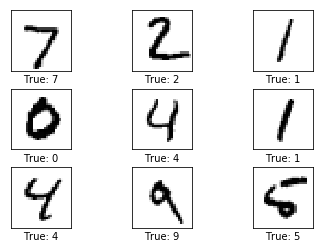

In [26]:
# get the first 10 images from the test-set
images = mnist.test.images[0:9]

# get the true classes for those images
cls_true = mnist.test.cls[0:9]

# plot the images and the labels using the plot helper function
plot_images(images=images, cls_true=cls_true)

## Helper function to plot example errors

In [27]:
def plot_examples_errors(cls_pred, correct):
    
    # use tensorflow to get a list of boolean values to check whether each test-image has been correctly
    # classified, and a list for the predicted class of each image
    # cls_pred is the predicted class number for all images in the test-set
    
    # negate the boolean array
    incorrect = (correct == False)
    
    # get the images from the test-set that have been incorrectly classified
    images = mnist.test.images[incorrect]
    
    # get the predicted class for the above incorrectly classified images
    cls_pred = cls_pred[incorrect]
    
    # get the true class for the above images
    cls_true = mnist.test.cls[incorrect]
    
    # plot the first 9 images
    plot_images(images=images[0:9], cls_true=cls_true[0:9], cls_pred=cls_pred[0:9])

## Helper function to plot confusion matrix

In [28]:
def plot_confusion_matrix(cls_pred):
    
    # get the true classifications for the test-set
    cls_true = mnist.test.cls
    
    # create a dictionary of test examples
    feed_dict_test = {x: mnist.test.images, y_true: mnist.test.labels, y_true_cls: cls_true}
    
    # cls_pred is an array of the predicted class number for all images in the test-set
    cls_pred = sess.run(y_pred_cls, feed_dict=feed_dict_test)
    
    # get the confusion matrix using sklearn
    cm = confusion_matrix(y_true=cls_true, y_pred=cls_pred)
    
    # print the confusion matrix as text
    for i in range(n_output):
        # append the appropriate label to each line
        label_name = "({}) {}".format(i, mnist.test.cls[i])
        print(cm[i, :], label_name)
    
    # plot the confusion matrix as an image
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    
    # adjust the plot
    plt.tight_layout()
    plt.colorbar()
    tick_marks = np.arange(n_output)
    plt.xticks(tick_marks, range(n_output))
    plt.yticks(tick_marks, range(n_output))
    plt.xlabel('Predicted')
    plt.ylabel('True')

## Helper Functions to Predict the Classifications

In [29]:
def predict_cls(images, labels, cls_true):
    
    # no of images
    num_images = len(images)
    
    # allocate an array for the predicted classes which will be calculated in batches and filled into this array
    cls_pred = np.zeros(shape=num_images, dtype=np.int)
    
    # calculate the predicted classes for the batches by iterating through all the batches
    
    # starting index (i) for the next batch
    i = 0
    
    while i < num_images:
        # ending index (j) for the next batch
        j = min(i + batch_size, num_images)
        
        # create a feed-dict with the images and labels between index i and j
        feed_dict = {x: images[i:j, :], y_true: labels[i:j, :]}
        
        # calculate the predicted class using TensorFlow
        cls_pred[i:j] = sess.run(y_pred_cls, feed_dict=feed_dict)
        
        # set the start-index of the next batch to the end-index of the current batch
        i = j
        
    # create a boolean array to check whether each image is correctly classified
    correct = (cls_true == cls_pred)
    label_names = mnist.test.labels
    return correct, cls_pred

In [30]:
# calculate predicted class for the test-set and validation-set

def predict_cls_test():
    return predict_cls(images = mnist.test.images, labels = mnist.test.labels, cls_true = mnist.test.cls)

def predict_cls_validation():
    return predict_cls(images = mnist.validation.images, labels = mnist.validation.labels, 
                       cls_true = mnist.validation.cls)

## Helper Functions to calculate the Classification Accuracy

In [31]:
# Define a helper function to calculates the classification accuracy given a boolean array to check if each image 
# was correctly classified.
# e.g: cls_accuracy([True, True, False, False, False]) = 2/5 = 0.4

def cls_accuracy(correct):
    # calculate the no of correctly classified images.
    # 0 = False, 1 = True
    correct_sum = correct.sum()
    
    # classification accuracy = no of correctly classified images / total no of images in the given dataset
    cls_accuracy = float(correct_sum) / len(correct)
    
    return cls_accuracy, correct_sum

In [32]:
# Define a function to find the classification accuracy on the validation set
def validation_accuracy():
    correct, _ = predict_cls_validation()
    
    return cls_accuracy(correct)

In [33]:
# Define a function to print the classification accuracy on the test-set

def print_test_accuracy(show_example_errors=False, show_confusion_matrix=False):
    
    # for all the images in the test-set, calculate the predicted class and check if they are correct
    correct, cls_pred = predict_cls_test()
    
    # classification accuracy and the no of correct classifications
    test_accuracy, num_correct = cls_accuracy(correct)
    
    # no of images being classified
    num_images = len(correct)
    
    
    # print the accuracy
    msg = "Test-Set Accuracy: {0:.1%} ({1} / {2})"
    print(msg.format(test_accuracy, num_correct, num_images))
    
    # plot some examples of misclassifications
    if show_example_errors:
        print("Example errors:")
        plot_examples_errors(cls_pred=cls_pred, correct=correct)
        
    # plot the confusion matrix
    if show_confusion_matrix:
        print("Confusion Matrix:")
        plot_confusion_matrix(cls_pred=cls_pred)

## Helper Function to Plot the Weights

In [34]:
def plot_weights(weights, cmap):
    # get the values of the weights from the tensorflow variable
    w = sess.run(weights)
    
    # print statistics for the weights
    print("Min:  {0:.5f}, Max:   {1:.5f}".format(w.min(), w.max()))
    print("Mean: {0:.5f}, Stdev: {1:.5f}".format(w.mean(), w.std()))
    
    # get the lowest and the highest values for the weights in order to correct the color intensity
    # across the images to compare them with each other
    w_min = np.min(w)
    w_max = np.max(w)
    abs_max = max(abs(w_min), abs(w_max))
    
    # create figure with 3x4 sub-plots where the last 2 sub-plots are unused.
    fig, axes = plt.subplots(3, 4)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    
    for i, ax in enumerate(axes.flat):
        # only use the weights for the first 10 sub-plots
        if i < 10:
            # get the weights for the ith digit and reshape it.
            # w.shape == (img_size_flat, 10)
            image = w[:, i].reshape(img_shape)
            
            # set the label for the sub-plot
            ax.set_xlabel("Weights: {0}".format(i))
            
            # plot the image
            ax.imshow(image, vmin=-abs_max, vmax=abs_max, interpolation='nearest', cmap=cmap)
            
        # remove ticks from each sub-plot
        ax.set_xticks([])
        ax.set_yticks([])
    
    # display the plot
    plt.show()

## Perform Training

### Performance of the model before any optimization

In [35]:
print("Accuracy of the model before training")
print_test_accuracy()

Accuracy of the model before training
Test-Set Accuracy: 11.1% (1111 / 10000)


## Performance of the Model after 1000 epochs

In [36]:
print("Starting Training Operation with a batch size of", batch_size)
optimize(n_epochs=1000)

Starting Training Operation with a batch size of 32
Epoch 1, Minibatch 1718/1718 
Training Accuracy:  59.4%, Validation Accuracy:  29.6%
Checkpoint Saved...
Epoch 2, Minibatch 1718/1718 
Training Accuracy:  31.2%, Validation Accuracy:  27.9%
Checkpoint Saved...
Epoch 3, Minibatch 1718/1718 
Training Accuracy:  18.8%, Validation Accuracy:  15.8%
Checkpoint Saved...
Epoch 4, Minibatch 1718/1718 
Training Accuracy:  62.5%, Validation Accuracy:  41.9%
Checkpoint Saved...
Epoch 5, Minibatch 1718/1718 
Training Accuracy:  56.2%, Validation Accuracy:  48.6%
Checkpoint Saved...
Epoch 6, Minibatch 1718/1718 
Training Accuracy:  68.8%, Validation Accuracy:  56.8%
Checkpoint Saved...
Epoch 7, Minibatch 1718/1718 
Training Accuracy:  56.2%, Validation Accuracy:  58.9%
Checkpoint Saved...
Epoch 8, Minibatch 1718/1718 
Training Accuracy:  78.1%, Validation Accuracy:  57.6%
Checkpoint Saved...
Epoch 9, Minibatch 1718/1718 
Training Accuracy:  96.9%, Validation Accuracy:  65.5%
Checkpoint Saved...
Epo

Checkpoint Saved...
Epoch 35, Minibatch 1718/1718 
Training Accuracy:  84.4%, Validation Accuracy:  82.6%
Checkpoint Saved...
Epoch 36, Minibatch 1718/1718 
Training Accuracy:  96.9%, Validation Accuracy:  82.5%
Checkpoint Saved...
Epoch 37, Minibatch 1718/1718 
Training Accuracy:  96.9%, Validation Accuracy:  83.1%
Checkpoint Saved...
Epoch 38, Minibatch 1718/1718 
Training Accuracy:  93.8%, Validation Accuracy:  85.1%
Checkpoint Saved...
Epoch 39, Minibatch 1718/1718 
Training Accuracy:  93.8%, Validation Accuracy:  84.4%
Checkpoint Saved...
Epoch 40, Minibatch 1718/1718 
Training Accuracy:  87.5%, Validation Accuracy:  83.2%
Checkpoint Saved...
Epoch 41, Minibatch 1718/1718 
Training Accuracy:  96.9%, Validation Accuracy:  81.7%
Checkpoint Saved...
Epoch 42, Minibatch 1718/1718 
Training Accuracy:  96.9%, Validation Accuracy:  80.7%
Checkpoint Saved...
Epoch 43, Minibatch 1718/1718 
Training Accuracy:  90.6%, Validation Accuracy:  80.3%
Checkpoint Saved...
Epoch 44, Minibatch 1718/1

Checkpoint Saved...
Epoch 69, Minibatch 1718/1718 
Training Accuracy:  90.6%, Validation Accuracy:  83.7%
Checkpoint Saved...
Epoch 70, Minibatch 1718/1718 
Training Accuracy:  87.5%, Validation Accuracy:  83.9%
Checkpoint Saved...
Epoch 71, Minibatch 1718/1718 
Training Accuracy:  87.5%, Validation Accuracy:  85.0%
Checkpoint Saved...
Epoch 72, Minibatch 1718/1718 
Training Accuracy:  87.5%, Validation Accuracy:  86.0%
Checkpoint Saved...
Epoch 73, Minibatch 1718/1718 
Training Accuracy:  93.8%, Validation Accuracy:  86.4%
Checkpoint Saved...
Epoch 74, Minibatch 1718/1718 
Training Accuracy:  90.6%, Validation Accuracy:  85.0%
Checkpoint Saved...
Epoch 75, Minibatch 1718/1718 
Training Accuracy:  93.8%, Validation Accuracy:  83.5%
Checkpoint Saved...
Epoch 76, Minibatch 1718/1718 
Training Accuracy:  96.9%, Validation Accuracy:  84.5%
Checkpoint Saved...
Epoch 77, Minibatch 1718/1718 
Training Accuracy:  93.8%, Validation Accuracy:  85.1%
Checkpoint Saved...
Epoch 78, Minibatch 1718/1

Checkpoint Saved...
Epoch 103, Minibatch 1718/1718 
Training Accuracy:  90.6%, Validation Accuracy:  86.1%
Checkpoint Saved...
Epoch 104, Minibatch 1718/1718 
Training Accuracy:  81.2%, Validation Accuracy:  86.4%
Checkpoint Saved...
Epoch 105, Minibatch 1718/1718 
Training Accuracy:  96.9%, Validation Accuracy:  85.7%
Checkpoint Saved...
Epoch 106, Minibatch 1718/1718 
Training Accuracy:  96.9%, Validation Accuracy:  85.6%
Checkpoint Saved...
Epoch 107, Minibatch 1718/1718 
Training Accuracy:  96.9%, Validation Accuracy:  86.1%
Checkpoint Saved...
Epoch 108, Minibatch 1718/1718 
Training Accuracy:  84.4%, Validation Accuracy:  87.9%
Checkpoint Saved...
Epoch 109, Minibatch 1718/1718 
Training Accuracy:  87.5%, Validation Accuracy:  85.9%
Checkpoint Saved...
Epoch 110, Minibatch 1718/1718 
Training Accuracy:  87.5%, Validation Accuracy:  81.8%
Checkpoint Saved...
Epoch 111, Minibatch 1718/1718 
Training Accuracy:  87.5%, Validation Accuracy:  78.7%
Checkpoint Saved...
Epoch 112, Miniba

Checkpoint Saved...
Epoch 137, Minibatch 1718/1718 
Training Accuracy:  93.8%, Validation Accuracy:  88.9%
Checkpoint Saved...
Epoch 138, Minibatch 1718/1718 
Training Accuracy:  93.8%, Validation Accuracy:  89.2%
Checkpoint Saved...
Epoch 139, Minibatch 1718/1718 
Training Accuracy:  84.4%, Validation Accuracy:  89.0%
Checkpoint Saved...
Epoch 140, Minibatch 1718/1718 
Training Accuracy:  90.6%, Validation Accuracy:  88.5%
Checkpoint Saved...
Epoch 141, Minibatch 1718/1718 
Training Accuracy:  96.9%, Validation Accuracy:  88.2%
Checkpoint Saved...
Epoch 142, Minibatch 1718/1718 
Training Accuracy:  96.9%, Validation Accuracy:  87.7%
Checkpoint Saved...
Epoch 143, Minibatch 1718/1718 
Training Accuracy:  87.5%, Validation Accuracy:  88.2%
Checkpoint Saved...
Epoch 144, Minibatch 1718/1718 
Training Accuracy:  96.9%, Validation Accuracy:  88.5%
Checkpoint Saved...
Epoch 145, Minibatch 1718/1718 
Training Accuracy:  96.9%, Validation Accuracy:  88.6%
Checkpoint Saved...
Epoch 146, Miniba

Checkpoint Saved...
Epoch 171, Minibatch 1718/1718 
Training Accuracy:  93.8%, Validation Accuracy:  85.7%
Checkpoint Saved...
Epoch 172, Minibatch 1718/1718 
Training Accuracy:  93.8%, Validation Accuracy:  85.8%
Checkpoint Saved...
Epoch 173, Minibatch 1718/1718 
Training Accuracy:  96.9%, Validation Accuracy:  86.6%
Checkpoint Saved...
Epoch 174, Minibatch 1718/1718 
Training Accuracy: 100.0%, Validation Accuracy:  87.6%
Checkpoint Saved...
Epoch 175, Minibatch 1718/1718 
Training Accuracy: 100.0%, Validation Accuracy:  89.2%
Checkpoint Saved...
Epoch 176, Minibatch 1718/1718 
Training Accuracy:  96.9%, Validation Accuracy:  89.1%
Checkpoint Saved...
Epoch 177, Minibatch 1718/1718 
Training Accuracy:  93.8%, Validation Accuracy:  88.2%
Checkpoint Saved...
Epoch 178, Minibatch 1718/1718 
Training Accuracy:  90.6%, Validation Accuracy:  88.2%
Checkpoint Saved...
Epoch 179, Minibatch 1718/1718 
Training Accuracy:  93.8%, Validation Accuracy:  88.3%
Checkpoint Saved...
Epoch 180, Miniba

Checkpoint Saved...
Epoch 205, Minibatch 1718/1718 
Training Accuracy:  87.5%, Validation Accuracy:  89.6%
Checkpoint Saved...
Epoch 206, Minibatch 1718/1718 
Training Accuracy:  87.5%, Validation Accuracy:  89.1%
Checkpoint Saved...
Epoch 207, Minibatch 1718/1718 
Training Accuracy:  93.8%, Validation Accuracy:  87.8%
Checkpoint Saved...
Epoch 208, Minibatch 1718/1718 
Training Accuracy:  93.8%, Validation Accuracy:  84.9%
Checkpoint Saved...
Epoch 209, Minibatch 1718/1718 
Training Accuracy:  90.6%, Validation Accuracy:  83.2%
Checkpoint Saved...
Epoch 210, Minibatch 1718/1718 
Training Accuracy:  87.5%, Validation Accuracy:  83.1%
Checkpoint Saved...
Epoch 211, Minibatch 1718/1718 
Training Accuracy:  93.8%, Validation Accuracy:  84.9%
Checkpoint Saved...
Epoch 212, Minibatch 1718/1718 
Training Accuracy:  90.6%, Validation Accuracy:  86.4%
Checkpoint Saved...
Epoch 213, Minibatch 1718/1718 
Training Accuracy:  90.6%, Validation Accuracy:  87.2%
Checkpoint Saved...
Epoch 214, Miniba

Checkpoint Saved...
Epoch 239, Minibatch 1718/1718 
Training Accuracy:  93.8%, Validation Accuracy:  87.8%
Checkpoint Saved...
Epoch 240, Minibatch 1718/1718 
Training Accuracy:  87.5%, Validation Accuracy:  89.0%
Checkpoint Saved...
Epoch 241, Minibatch 1718/1718 
Training Accuracy:  87.5%, Validation Accuracy:  90.1%
Checkpoint Saved...
Epoch 242, Minibatch 1718/1718 
Training Accuracy: 100.0%, Validation Accuracy:  88.8%
Checkpoint Saved...
Epoch 243, Minibatch 1718/1718 
Training Accuracy:  93.8%, Validation Accuracy:  87.1%
Checkpoint Saved...
Epoch 244, Minibatch 1718/1718 
Training Accuracy:  90.6%, Validation Accuracy:  87.2%
Checkpoint Saved...
Epoch 245, Minibatch 1718/1718 
Training Accuracy:  84.4%, Validation Accuracy:  89.1%
Checkpoint Saved...
Epoch 246, Minibatch 1718/1718 
Training Accuracy:  93.8%, Validation Accuracy:  88.6%
Checkpoint Saved...
Epoch 247, Minibatch 1718/1718 
Training Accuracy:  93.8%, Validation Accuracy:  87.0%
Checkpoint Saved...
Epoch 248, Miniba

Checkpoint Saved...
Epoch 273, Minibatch 1718/1718 
Training Accuracy:  90.6%, Validation Accuracy:  89.5%
Checkpoint Saved...
Epoch 274, Minibatch 1718/1718 
Training Accuracy:  90.6%, Validation Accuracy:  89.6%
Checkpoint Saved...
Epoch 275, Minibatch 1718/1718 
Training Accuracy:  96.9%, Validation Accuracy:  89.8%
Checkpoint Saved...
Epoch 276, Minibatch 1718/1718 
Training Accuracy:  87.5%, Validation Accuracy:  90.1%
Checkpoint Saved...
Epoch 277, Minibatch 1718/1718 
Training Accuracy:  96.9%, Validation Accuracy:  90.1%
Checkpoint Saved...
Epoch 278, Minibatch 1718/1718 
Training Accuracy:  93.8%, Validation Accuracy:  90.3%
Checkpoint Saved...
Epoch 279, Minibatch 1718/1718 
Training Accuracy:  90.6%, Validation Accuracy:  90.6%
Checkpoint Saved...
Epoch 280, Minibatch 1718/1718 
Training Accuracy:  93.8%, Validation Accuracy:  90.9%
Checkpoint Saved...
Epoch 281, Minibatch 1718/1718 
Training Accuracy:  90.6%, Validation Accuracy:  91.4%
Checkpoint Saved...
Epoch 282, Miniba

Checkpoint Saved...
Epoch 307, Minibatch 1718/1718 
Training Accuracy:  96.9%, Validation Accuracy:  90.5%
Checkpoint Saved...
Epoch 308, Minibatch 1718/1718 
Training Accuracy:  87.5%, Validation Accuracy:  90.2%
Checkpoint Saved...
Epoch 309, Minibatch 1718/1718 
Training Accuracy:  93.8%, Validation Accuracy:  89.4%
Checkpoint Saved...
Epoch 310, Minibatch 1718/1718 
Training Accuracy:  87.5%, Validation Accuracy:  89.4%
Checkpoint Saved...
Epoch 311, Minibatch 1718/1718 
Training Accuracy: 100.0%, Validation Accuracy:  89.3%
Checkpoint Saved...
Epoch 312, Minibatch 1718/1718 
Training Accuracy: 100.0%, Validation Accuracy:  89.6%
Checkpoint Saved...
Epoch 313, Minibatch 1718/1718 
Training Accuracy:  93.8%, Validation Accuracy:  89.8%
Checkpoint Saved...
Epoch 314, Minibatch 1718/1718 
Training Accuracy:  93.8%, Validation Accuracy:  89.6%
Checkpoint Saved...
Epoch 315, Minibatch 1718/1718 
Training Accuracy:  93.8%, Validation Accuracy:  89.9%
Checkpoint Saved...
Epoch 316, Miniba

Epoch 340, Minibatch 1718/1718 
Training Accuracy:  87.5%, Validation Accuracy:  92.3%
Checkpoint Saved...
Epoch 341, Minibatch 1718/1718 
Training Accuracy:  96.9%, Validation Accuracy:  92.8%
Checkpoint Saved...
Epoch 342, Minibatch 1718/1718 
Training Accuracy:  90.6%, Validation Accuracy:  92.2%
Checkpoint Saved...
Epoch 343, Minibatch 1718/1718 
Training Accuracy:  87.5%, Validation Accuracy:  92.1%
Checkpoint Saved...
Epoch 344, Minibatch 1718/1718 
Training Accuracy:  90.6%, Validation Accuracy:  91.9%
Checkpoint Saved...
Epoch 345, Minibatch 1718/1718 
Training Accuracy:  87.5%, Validation Accuracy:  92.0%
Checkpoint Saved...
Epoch 346, Minibatch 1718/1718 
Training Accuracy:  87.5%, Validation Accuracy:  92.2%
Checkpoint Saved...
Epoch 347, Minibatch 1718/1718 
Training Accuracy:  96.9%, Validation Accuracy:  92.4%
Checkpoint Saved...
Epoch 348, Minibatch 1718/1718 
Training Accuracy:  96.9%, Validation Accuracy:  92.5%
Checkpoint Saved...
Epoch 349, Minibatch 1718/1718 
Train

Checkpoint Saved...
Epoch 374, Minibatch 1718/1718 
Training Accuracy:  84.4%, Validation Accuracy:  89.7%
Checkpoint Saved...
Epoch 375, Minibatch 1718/1718 
Training Accuracy:  90.6%, Validation Accuracy:  90.6%
Checkpoint Saved...
Epoch 376, Minibatch 1718/1718 
Training Accuracy:  96.9%, Validation Accuracy:  91.3%
Checkpoint Saved...
Epoch 377, Minibatch 1718/1718 
Training Accuracy:  96.9%, Validation Accuracy:  91.0%
Checkpoint Saved...
Epoch 378, Minibatch 1718/1718 
Training Accuracy:  90.6%, Validation Accuracy:  89.6%
Checkpoint Saved...
Epoch 379, Minibatch 1718/1718 
Training Accuracy:  87.5%, Validation Accuracy:  90.5%
Checkpoint Saved...
Epoch 380, Minibatch 1718/1718 
Training Accuracy:  96.9%, Validation Accuracy:  91.1%
Checkpoint Saved...
Epoch 381, Minibatch 1718/1718 
Training Accuracy:  93.8%, Validation Accuracy:  91.1%
Checkpoint Saved...
Epoch 382, Minibatch 1718/1718 
Training Accuracy:  87.5%, Validation Accuracy:  91.2%
Checkpoint Saved...
Epoch 383, Miniba

Checkpoint Saved...
Epoch 408, Minibatch 1718/1718 
Training Accuracy:  87.5%, Validation Accuracy:  85.6%
Checkpoint Saved...
Epoch 409, Minibatch 1718/1718 
Training Accuracy:  90.6%, Validation Accuracy:  86.6%
Checkpoint Saved...
Epoch 410, Minibatch 1718/1718 
Training Accuracy:  90.6%, Validation Accuracy:  89.0%
Checkpoint Saved...
Epoch 411, Minibatch 1718/1718 
Training Accuracy: 100.0%, Validation Accuracy:  91.6%
Checkpoint Saved...
Epoch 412, Minibatch 1718/1718 
Training Accuracy:  96.9%, Validation Accuracy:  91.8%
Checkpoint Saved...
Epoch 413, Minibatch 1718/1718 
Training Accuracy:  96.9%, Validation Accuracy:  91.1%
Checkpoint Saved...
Epoch 414, Minibatch 1718/1718 
Training Accuracy:  90.6%, Validation Accuracy:  90.1%
Checkpoint Saved...
Epoch 415, Minibatch 1718/1718 
Training Accuracy: 100.0%, Validation Accuracy:  88.9%
Checkpoint Saved...
Epoch 416, Minibatch 1718/1718 
Training Accuracy:  90.6%, Validation Accuracy:  88.9%
Checkpoint Saved...
Epoch 417, Miniba

Checkpoint Saved...
Epoch 442, Minibatch 1718/1718 
Training Accuracy:  93.8%, Validation Accuracy:  90.4%
Checkpoint Saved...
Epoch 443, Minibatch 1718/1718 
Training Accuracy:  93.8%, Validation Accuracy:  89.8%
Checkpoint Saved...
Epoch 444, Minibatch 1718/1718 
Training Accuracy:  90.6%, Validation Accuracy:  89.7%
Checkpoint Saved...
Epoch 445, Minibatch 1718/1718 
Training Accuracy:  87.5%, Validation Accuracy:  89.6%
Checkpoint Saved...
Epoch 446, Minibatch 1718/1718 
Training Accuracy:  90.6%, Validation Accuracy:  89.7%
Checkpoint Saved...
Epoch 447, Minibatch 1718/1718 
Training Accuracy:  93.8%, Validation Accuracy:  90.9%
Checkpoint Saved...
Epoch 448, Minibatch 1718/1718 
Training Accuracy:  87.5%, Validation Accuracy:  91.5%
Checkpoint Saved...
Epoch 449, Minibatch 1718/1718 
Training Accuracy:  96.9%, Validation Accuracy:  91.6%
Checkpoint Saved...
Epoch 450, Minibatch 1718/1718 
Training Accuracy: 100.0%, Validation Accuracy:  91.0%
Checkpoint Saved...
Epoch 451, Miniba

Checkpoint Saved...
Epoch 476, Minibatch 1718/1718 
Training Accuracy:  90.6%, Validation Accuracy:  92.7%
Checkpoint Saved...
Epoch 477, Minibatch 1718/1718 
Training Accuracy:  93.8%, Validation Accuracy:  92.6%
Checkpoint Saved...
Epoch 478, Minibatch 1718/1718 
Training Accuracy:  96.9%, Validation Accuracy:  92.5%
Checkpoint Saved...
Epoch 479, Minibatch 1718/1718 
Training Accuracy:  96.9%, Validation Accuracy:  92.3%
Checkpoint Saved...
Epoch 480, Minibatch 1718/1718 
Training Accuracy:  96.9%, Validation Accuracy:  92.1%
Checkpoint Saved...
Epoch 481, Minibatch 1718/1718 
Training Accuracy:  96.9%, Validation Accuracy:  92.0%
Checkpoint Saved...
Epoch 482, Minibatch 1718/1718 
Training Accuracy:  93.8%, Validation Accuracy:  92.0%
Checkpoint Saved...
Epoch 483, Minibatch 1718/1718 
Training Accuracy:  96.9%, Validation Accuracy:  91.7%
Checkpoint Saved...
Epoch 484, Minibatch 1718/1718 
Training Accuracy:  96.9%, Validation Accuracy:  91.3%
Checkpoint Saved...
Epoch 485, Miniba

Checkpoint Saved...
Epoch 510, Minibatch 1718/1718 
Training Accuracy:  90.6%, Validation Accuracy:  90.1%
Checkpoint Saved...
Epoch 511, Minibatch 1718/1718 
Training Accuracy:  96.9%, Validation Accuracy:  90.3%
Checkpoint Saved...
Epoch 512, Minibatch 1718/1718 
Training Accuracy:  84.4%, Validation Accuracy:  90.4%
Checkpoint Saved...
Epoch 513, Minibatch 1718/1718 
Training Accuracy:  93.8%, Validation Accuracy:  90.1%
Checkpoint Saved...
Epoch 514, Minibatch 1718/1718 
Training Accuracy:  87.5%, Validation Accuracy:  89.8%
Checkpoint Saved...
Epoch 515, Minibatch 1718/1718 
Training Accuracy:  93.8%, Validation Accuracy:  90.0%
Checkpoint Saved...
Epoch 516, Minibatch 1718/1718 
Training Accuracy:  93.8%, Validation Accuracy:  90.3%
Checkpoint Saved...
Epoch 517, Minibatch 1718/1718 
Training Accuracy:  93.8%, Validation Accuracy:  90.5%
Checkpoint Saved...
Epoch 518, Minibatch 1718/1718 
Training Accuracy: 100.0%, Validation Accuracy:  90.5%
Checkpoint Saved...
Epoch 519, Miniba

Checkpoint Saved...
Epoch 544, Minibatch 1718/1718 
Training Accuracy: 100.0%, Validation Accuracy:  88.8%
Checkpoint Saved...
Epoch 545, Minibatch 1718/1718 
Training Accuracy:  87.5%, Validation Accuracy:  88.1%
Checkpoint Saved...
Epoch 546, Minibatch 1718/1718 
Training Accuracy: 100.0%, Validation Accuracy:  88.7%
Checkpoint Saved...
Epoch 547, Minibatch 1718/1718 
Training Accuracy:  78.1%, Validation Accuracy:  90.1%
Checkpoint Saved...
Epoch 548, Minibatch 1718/1718 
Training Accuracy:  75.0%, Validation Accuracy:  91.2%
Checkpoint Saved...
Epoch 549, Minibatch 1718/1718 
Training Accuracy:  90.6%, Validation Accuracy:  91.5%
Checkpoint Saved...
Epoch 550, Minibatch 1718/1718 
Training Accuracy:  93.8%, Validation Accuracy:  91.6%
Checkpoint Saved...
Epoch 551, Minibatch 1718/1718 
Training Accuracy: 100.0%, Validation Accuracy:  91.1%
Checkpoint Saved...
Epoch 552, Minibatch 1718/1718 
Training Accuracy:  90.6%, Validation Accuracy:  91.7%
Checkpoint Saved...
Epoch 553, Miniba

Checkpoint Saved...
Epoch 578, Minibatch 1718/1718 
Training Accuracy:  90.6%, Validation Accuracy:  90.7%
Checkpoint Saved...
Epoch 579, Minibatch 1718/1718 
Training Accuracy:  96.9%, Validation Accuracy:  90.9%
Checkpoint Saved...
Epoch 580, Minibatch 1718/1718 
Training Accuracy:  96.9%, Validation Accuracy:  91.5%
Checkpoint Saved...
Epoch 581, Minibatch 1718/1718 
Training Accuracy:  90.6%, Validation Accuracy:  92.0%
Checkpoint Saved...
Epoch 582, Minibatch 1718/1718 
Training Accuracy:  93.8%, Validation Accuracy:  92.1%
Checkpoint Saved...
Epoch 583, Minibatch 1718/1718 
Training Accuracy:  93.8%, Validation Accuracy:  92.5%
Checkpoint Saved...
Epoch 584, Minibatch 1718/1718 
Training Accuracy:  93.8%, Validation Accuracy:  92.8%
Checkpoint Saved...
Epoch 585, Minibatch 1718/1718 
Training Accuracy:  90.6%, Validation Accuracy:  93.0%
Checkpoint Saved...
Epoch 586, Minibatch 1718/1718 
Training Accuracy:  90.6%, Validation Accuracy:  92.5%
Checkpoint Saved...
Epoch 587, Miniba

Checkpoint Saved...
Epoch 612, Minibatch 1718/1718 
Training Accuracy:  93.8%, Validation Accuracy:  92.4%
Checkpoint Saved...
Epoch 613, Minibatch 1718/1718 
Training Accuracy:  93.8%, Validation Accuracy:  92.1%
Checkpoint Saved...
Epoch 614, Minibatch 1718/1718 
Training Accuracy:  87.5%, Validation Accuracy:  91.9%
Checkpoint Saved...
Epoch 615, Minibatch 1718/1718 
Training Accuracy:  90.6%, Validation Accuracy:  92.3%
Checkpoint Saved...
Epoch 616, Minibatch 1718/1718 
Training Accuracy:  90.6%, Validation Accuracy:  92.6%
Checkpoint Saved...
Epoch 617, Minibatch 1718/1718 
Training Accuracy:  84.4%, Validation Accuracy:  92.1%
Checkpoint Saved...
Epoch 618, Minibatch 1718/1718 
Training Accuracy:  93.8%, Validation Accuracy:  90.5%
Checkpoint Saved...
Epoch 619, Minibatch 1718/1718 
Training Accuracy:  93.8%, Validation Accuracy:  88.8%
Checkpoint Saved...
Epoch 620, Minibatch 1718/1718 
Training Accuracy:  84.4%, Validation Accuracy:  88.9%
Checkpoint Saved...
Epoch 621, Miniba

Checkpoint Saved...
Epoch 646, Minibatch 1718/1718 
Training Accuracy:  96.9%, Validation Accuracy:  90.4%
Checkpoint Saved...
Epoch 647, Minibatch 1718/1718 
Training Accuracy:  96.9%, Validation Accuracy:  89.8%
Checkpoint Saved...
Epoch 648, Minibatch 1718/1718 
Training Accuracy:  93.8%, Validation Accuracy:  89.9%
Checkpoint Saved...
Epoch 649, Minibatch 1718/1718 
Training Accuracy:  90.6%, Validation Accuracy:  90.2%
Checkpoint Saved...
Epoch 650, Minibatch 1718/1718 
Training Accuracy:  90.6%, Validation Accuracy:  90.3%
Checkpoint Saved...
Epoch 651, Minibatch 1718/1718 
Training Accuracy:  93.8%, Validation Accuracy:  90.0%
Checkpoint Saved...
Epoch 652, Minibatch 1718/1718 
Training Accuracy: 100.0%, Validation Accuracy:  90.0%
Checkpoint Saved...
Epoch 653, Minibatch 1718/1718 
Training Accuracy:  93.8%, Validation Accuracy:  90.3%
Checkpoint Saved...
Epoch 654, Minibatch 1718/1718 
Training Accuracy:  96.9%, Validation Accuracy:  90.4%
Checkpoint Saved...
Epoch 655, Miniba

Checkpoint Saved...
Epoch 680, Minibatch 1718/1718 
Training Accuracy:  84.4%, Validation Accuracy:  92.1%
Checkpoint Saved...
Epoch 681, Minibatch 1718/1718 
Training Accuracy:  96.9%, Validation Accuracy:  91.6%
Checkpoint Saved...
Epoch 682, Minibatch 1718/1718 
Training Accuracy:  87.5%, Validation Accuracy:  90.8%
Checkpoint Saved...
Epoch 683, Minibatch 1718/1718 
Training Accuracy:  87.5%, Validation Accuracy:  90.6%
Checkpoint Saved...
Epoch 684, Minibatch 1718/1718 
Training Accuracy:  93.8%, Validation Accuracy:  90.2%
Checkpoint Saved...
Epoch 685, Minibatch 1718/1718 
Training Accuracy:  87.5%, Validation Accuracy:  90.1%
Checkpoint Saved...
Epoch 686, Minibatch 1718/1718 
Training Accuracy:  93.8%, Validation Accuracy:  90.7%
Checkpoint Saved...
Epoch 687, Minibatch 1718/1718 
Training Accuracy: 100.0%, Validation Accuracy:  91.1%
Checkpoint Saved...
Epoch 688, Minibatch 1718/1718 
Training Accuracy: 100.0%, Validation Accuracy:  91.3%
Checkpoint Saved...
Epoch 689, Miniba

Checkpoint Saved...
Epoch 714, Minibatch 1718/1718 
Training Accuracy:  93.8%, Validation Accuracy:  91.6%
Checkpoint Saved...
Epoch 715, Minibatch 1718/1718 
Training Accuracy: 100.0%, Validation Accuracy:  91.7%
Checkpoint Saved...
Epoch 716, Minibatch 1718/1718 
Training Accuracy:  93.8%, Validation Accuracy:  91.4%
Checkpoint Saved...
Epoch 717, Minibatch 1718/1718 
Training Accuracy:  93.8%, Validation Accuracy:  91.0%
Checkpoint Saved...
Epoch 718, Minibatch 1718/1718 
Training Accuracy:  93.8%, Validation Accuracy:  90.8%
Checkpoint Saved...
Epoch 719, Minibatch 1718/1718 
Training Accuracy: 100.0%, Validation Accuracy:  90.5%
Checkpoint Saved...
Epoch 720, Minibatch 1718/1718 
Training Accuracy:  96.9%, Validation Accuracy:  90.6%
Checkpoint Saved...
Epoch 721, Minibatch 1718/1718 
Training Accuracy:  96.9%, Validation Accuracy:  90.6%
Checkpoint Saved...
Epoch 722, Minibatch 1718/1718 
Training Accuracy:  96.9%, Validation Accuracy:  90.7%
Checkpoint Saved...
Epoch 723, Miniba

Checkpoint Saved...
Epoch 748, Minibatch 1718/1718 
Training Accuracy:  90.6%, Validation Accuracy:  90.3%
Checkpoint Saved...
Epoch 749, Minibatch 1718/1718 
Training Accuracy:  96.9%, Validation Accuracy:  89.7%
Checkpoint Saved...
Epoch 750, Minibatch 1718/1718 
Training Accuracy:  93.8%, Validation Accuracy:  89.2%
Checkpoint Saved...
Epoch 751, Minibatch 1718/1718 
Training Accuracy:  93.8%, Validation Accuracy:  88.7%
Checkpoint Saved...
Epoch 752, Minibatch 1718/1718 
Training Accuracy:  96.9%, Validation Accuracy:  89.0%
Checkpoint Saved...
Epoch 753, Minibatch 1718/1718 
Training Accuracy:  90.6%, Validation Accuracy:  89.5%
Checkpoint Saved...
Epoch 754, Minibatch 1718/1718 
Training Accuracy:  84.4%, Validation Accuracy:  90.0%
Checkpoint Saved...
Epoch 755, Minibatch 1718/1718 
Training Accuracy:  84.4%, Validation Accuracy:  90.5%
Checkpoint Saved...
Epoch 756, Minibatch 1718/1718 
Training Accuracy:  93.8%, Validation Accuracy:  91.1%
Checkpoint Saved...
Epoch 757, Miniba

Epoch 781, Minibatch 1718/1718 
Training Accuracy:  93.8%, Validation Accuracy:  92.1%
Checkpoint Saved...
Epoch 782, Minibatch 1718/1718 
Training Accuracy:  93.8%, Validation Accuracy:  92.1%
Checkpoint Saved...
Epoch 783, Minibatch 1718/1718 
Training Accuracy:  93.8%, Validation Accuracy:  92.3%
Checkpoint Saved...
Epoch 784, Minibatch 1718/1718 
Training Accuracy:  96.9%, Validation Accuracy:  92.3%
Checkpoint Saved...
Epoch 785, Minibatch 1718/1718 
Training Accuracy:  87.5%, Validation Accuracy:  92.7%
Checkpoint Saved...
Epoch 786, Minibatch 1718/1718 
Training Accuracy:  87.5%, Validation Accuracy:  92.9%
Checkpoint Saved...
Epoch 787, Minibatch 1718/1718 
Training Accuracy:  93.8%, Validation Accuracy:  92.9%
Checkpoint Saved...
Epoch 788, Minibatch 1718/1718 
Training Accuracy:  96.9%, Validation Accuracy:  92.6%
Checkpoint Saved...
Epoch 789, Minibatch 1718/1718 
Training Accuracy:  96.9%, Validation Accuracy:  92.5%
Checkpoint Saved...
Epoch 790, Minibatch 1718/1718 
Train

Checkpoint Saved...
Epoch 815, Minibatch 1718/1718 
Training Accuracy:  90.6%, Validation Accuracy:  92.6%
Checkpoint Saved...
Epoch 816, Minibatch 1718/1718 
Training Accuracy: 100.0%, Validation Accuracy:  92.8%
Checkpoint Saved...
Epoch 817, Minibatch 1718/1718 
Training Accuracy:  93.8%, Validation Accuracy:  93.1%
Checkpoint Saved...
Epoch 818, Minibatch 1718/1718 
Training Accuracy: 100.0%, Validation Accuracy:  93.0%
Checkpoint Saved...
Epoch 819, Minibatch 1718/1718 
Training Accuracy:  87.5%, Validation Accuracy:  92.9%
Checkpoint Saved...
Epoch 820, Minibatch 1718/1718 
Training Accuracy:  96.9%, Validation Accuracy:  92.9%
Checkpoint Saved...
Epoch 821, Minibatch 1718/1718 
Training Accuracy:  93.8%, Validation Accuracy:  93.0%
Checkpoint Saved...
Epoch 822, Minibatch 1718/1718 
Training Accuracy:  90.6%, Validation Accuracy:  93.1%
Checkpoint Saved...
Epoch 823, Minibatch 1718/1718 
Training Accuracy:  87.5%, Validation Accuracy:  92.9%
Checkpoint Saved...
Epoch 824, Miniba

Checkpoint Saved...
Epoch 849, Minibatch 1718/1718 
Training Accuracy:  93.8%, Validation Accuracy:  90.3%
Checkpoint Saved...
Epoch 850, Minibatch 1718/1718 
Training Accuracy:  93.8%, Validation Accuracy:  90.1%
Checkpoint Saved...
Epoch 851, Minibatch 1718/1718 
Training Accuracy:  96.9%, Validation Accuracy:  89.9%
Checkpoint Saved...
Epoch 852, Minibatch 1718/1718 
Training Accuracy:  93.8%, Validation Accuracy:  89.7%
Checkpoint Saved...
Epoch 853, Minibatch 1718/1718 
Training Accuracy:  96.9%, Validation Accuracy:  89.6%
Checkpoint Saved...
Epoch 854, Minibatch 1718/1718 
Training Accuracy:  93.8%, Validation Accuracy:  89.4%
Checkpoint Saved...
Epoch 855, Minibatch 1718/1718 
Training Accuracy:  78.1%, Validation Accuracy:  89.7%
Checkpoint Saved...
Epoch 856, Minibatch 1718/1718 
Training Accuracy:  84.4%, Validation Accuracy:  91.4%
Checkpoint Saved...
Epoch 857, Minibatch 1718/1718 
Training Accuracy:  87.5%, Validation Accuracy:  92.3%
Checkpoint Saved...
Epoch 858, Miniba

Checkpoint Saved...
Epoch 883, Minibatch 1718/1718 
Training Accuracy: 100.0%, Validation Accuracy:  93.3%
Checkpoint Saved...
Epoch 884, Minibatch 1718/1718 
Training Accuracy: 100.0%, Validation Accuracy:  93.1%
Checkpoint Saved...
Epoch 885, Minibatch 1718/1718 
Training Accuracy:  96.9%, Validation Accuracy:  92.8%
Checkpoint Saved...
Epoch 886, Minibatch 1718/1718 
Training Accuracy:  96.9%, Validation Accuracy:  92.9%
Checkpoint Saved...
Epoch 887, Minibatch 1718/1718 
Training Accuracy:  90.6%, Validation Accuracy:  93.1%
Checkpoint Saved...
Epoch 888, Minibatch 1718/1718 
Training Accuracy:  96.9%, Validation Accuracy:  92.9%
Checkpoint Saved...
Epoch 889, Minibatch 1718/1718 
Training Accuracy:  93.8%, Validation Accuracy:  92.8%
Checkpoint Saved...
Epoch 890, Minibatch 1718/1718 
Training Accuracy: 100.0%, Validation Accuracy:  93.0%
Checkpoint Saved...
Epoch 891, Minibatch 1718/1718 
Training Accuracy:  90.6%, Validation Accuracy:  93.0%
Checkpoint Saved...
Epoch 892, Miniba

Checkpoint Saved...
Epoch 917, Minibatch 1718/1718 
Training Accuracy:  96.9%, Validation Accuracy:  93.5%
Checkpoint Saved...
Epoch 918, Minibatch 1718/1718 
Training Accuracy: 100.0%, Validation Accuracy:  93.3%
Checkpoint Saved...
Epoch 919, Minibatch 1718/1718 
Training Accuracy:  93.8%, Validation Accuracy:  93.0%
Checkpoint Saved...
Epoch 920, Minibatch 1718/1718 
Training Accuracy:  87.5%, Validation Accuracy:  92.5%
Checkpoint Saved...
Epoch 921, Minibatch 1718/1718 
Training Accuracy:  93.8%, Validation Accuracy:  92.1%
Checkpoint Saved...
Epoch 922, Minibatch 1718/1718 
Training Accuracy:  93.8%, Validation Accuracy:  92.1%
Checkpoint Saved...
Epoch 923, Minibatch 1718/1718 
Training Accuracy: 100.0%, Validation Accuracy:  91.8%
Checkpoint Saved...
Epoch 924, Minibatch 1718/1718 
Training Accuracy:  93.8%, Validation Accuracy:  91.9%
Checkpoint Saved...
Epoch 925, Minibatch 1718/1718 
Training Accuracy:  87.5%, Validation Accuracy:  92.3%
Checkpoint Saved...
Epoch 926, Miniba

Checkpoint Saved...
Epoch 951, Minibatch 1718/1718 
Training Accuracy:  96.9%, Validation Accuracy:  93.9%
Checkpoint Saved...
Epoch 952, Minibatch 1718/1718 
Training Accuracy: 100.0%, Validation Accuracy:  94.2%
Checkpoint Saved...
Epoch 953, Minibatch 1718/1718 
Training Accuracy:  87.5%, Validation Accuracy:  94.4%
Checkpoint Saved...
Epoch 954, Minibatch 1718/1718 
Training Accuracy: 100.0%, Validation Accuracy:  94.4%
Checkpoint Saved...
Epoch 955, Minibatch 1718/1718 
Training Accuracy: 100.0%, Validation Accuracy:  94.5%
Checkpoint Saved...
Epoch 956, Minibatch 1718/1718 
Training Accuracy: 100.0%, Validation Accuracy:  94.4%
Checkpoint Saved...
Epoch 957, Minibatch 1718/1718 
Training Accuracy:  96.9%, Validation Accuracy:  94.1%
Checkpoint Saved...
Epoch 958, Minibatch 1718/1718 
Training Accuracy:  96.9%, Validation Accuracy:  94.0%
Checkpoint Saved...
Epoch 959, Minibatch 1718/1718 
Training Accuracy:  93.8%, Validation Accuracy:  93.8%
Checkpoint Saved...
Epoch 960, Miniba

Checkpoint Saved...
Epoch 985, Minibatch 1718/1718 
Training Accuracy: 100.0%, Validation Accuracy:  92.7%
Checkpoint Saved...
Epoch 986, Minibatch 1718/1718 
Training Accuracy:  96.9%, Validation Accuracy:  91.4%
Checkpoint Saved...
Epoch 987, Minibatch 1718/1718 
Training Accuracy:  96.9%, Validation Accuracy:  90.3%
Checkpoint Saved...
Epoch 988, Minibatch 1718/1718 
Training Accuracy: 100.0%, Validation Accuracy:  89.9%
Checkpoint Saved...
Epoch 989, Minibatch 1718/1718 
Training Accuracy: 100.0%, Validation Accuracy:  89.7%
Checkpoint Saved...
Epoch 990, Minibatch 1718/1718 
Training Accuracy:  96.9%, Validation Accuracy:  89.3%
Checkpoint Saved...
Epoch 991, Minibatch 1718/1718 
Training Accuracy: 100.0%, Validation Accuracy:  89.1%
Checkpoint Saved...
Epoch 992, Minibatch 1718/1718 
Training Accuracy:  96.9%, Validation Accuracy:  88.8%
Checkpoint Saved...
Epoch 993, Minibatch 1718/1718 
Training Accuracy:  93.8%, Validation Accuracy:  89.1%
Checkpoint Saved...
Epoch 994, Miniba

Accuracy of the model after training for 1000 epochs
Test-Set Accuracy: 92.9% (9294 / 10000)
Example errors:


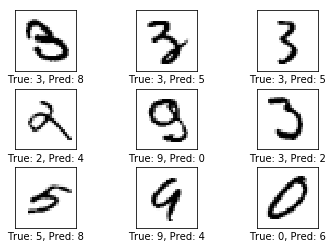

Confusion Matrix:
[929   0   2   0   1  17  24   2   5   0] (0) 7
[   0 1121    3    0    1    3    3    1    3    0] (1) 2
[  4   6 975   8   7   5   5  11  11   0] (2) 1
[  3   4  29 853   0  82   5  15  17   2] (3) 0
[  3   1   3   0 942   0   4   1   4  24] (4) 4
[ 10   0   1   6   9 817  11   5  26   7] (5) 1
[ 23   4   0   0  14  14 899   0   4   0] (6) 4
[  3  14  17   0   6   2   0 974   1  11] (7) 9
[  5   3   6  13   9  13  20   8 890   7] (8) 5
[ 10   6   0   7  52  20   0  11   9 894] (9) 9

Actual Labels:
[7 2 1 0 4 1 4 9 5]


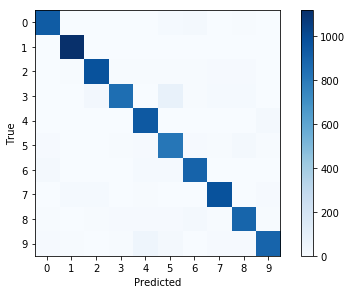

In [37]:
print("Accuracy of the model after training for 1000 epochs")
print_test_accuracy(show_example_errors=True, show_confusion_matrix=True)

mnist.test.cls = np.argmax(mnist.test.labels, axis=1)
print("")
print("Actual Labels:")
print(mnist.test.cls[0:9])

## Plot the Weights

Min:  -1.42705, Max:   1.32486
Mean: -0.02862, Stdev: 0.07814


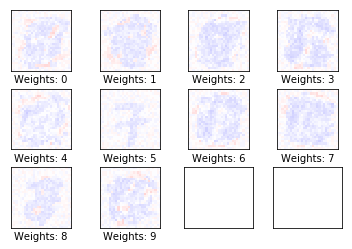

In [38]:
plot_weights(weights=W_1, cmap='seismic')

In [39]:
# sess.close()